In [1]:
import json

In [2]:
descriptions = {}

with open("./../data/races/races-description.jl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        if (data.get('id', "TBD") != "TBD"):
            descriptions[data['id']] = data
        else:
            descriptions[f"TBD_{data['name']}"] = data

In [52]:
len(descriptions)

223

In [4]:
customize_stop_words = [
    "Race", "Races", "race",
    "info", "about", 
    "finish", "line", "swim", "bike", "run", 'athlete', 'ironman'
]

In [30]:
import pandas as pd
import pathlib as pl
import numpy as np

def _read_all_reviews_():
    all_reviews = []
    for p in pl.Path('../data/txt_sentoken/pos').iterdir():
        file = open(p, 'r')
        all_reviews.append({'reviews_content': file.read(), 'category': 'positive'})
        file.close()
    for p in pl.Path('../data/txt_sentoken/neg').iterdir():
        file = open(p, 'r')
        all_reviews.append({'reviews_content': file.read(), 'category': 'negative'})
        file.close()
    all_reviews_df = pd.DataFrame(all_reviews)
    return all_reviews_df

# print(_read_all_reviews_())

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import preprocess_string
from sklearn import utils
from sklearn import metrics
from tqdm import tqdm
import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):
    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count()

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(preprocess_string(row['description']), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)
        for epoch in range(self.epochs):
            model.train(utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha
            self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(preprocess_string(row['description'])) for index, row in df_x.iterrows()]))

In [93]:
data = pd.DataFrame(list(descriptions.values()))

# embed descriptions into vectors
doc = Doc2VecTransformer(vector_size=5)
doc.fit(data[['description']])
res = doc.transform(data[['description']])

# run PCA
pca = PCA(n_components=5)
pca.fit(res)
out = pca.transform(res)

100%|██████████| 223/223 [00:00<00:00, 1295470.63it/s]


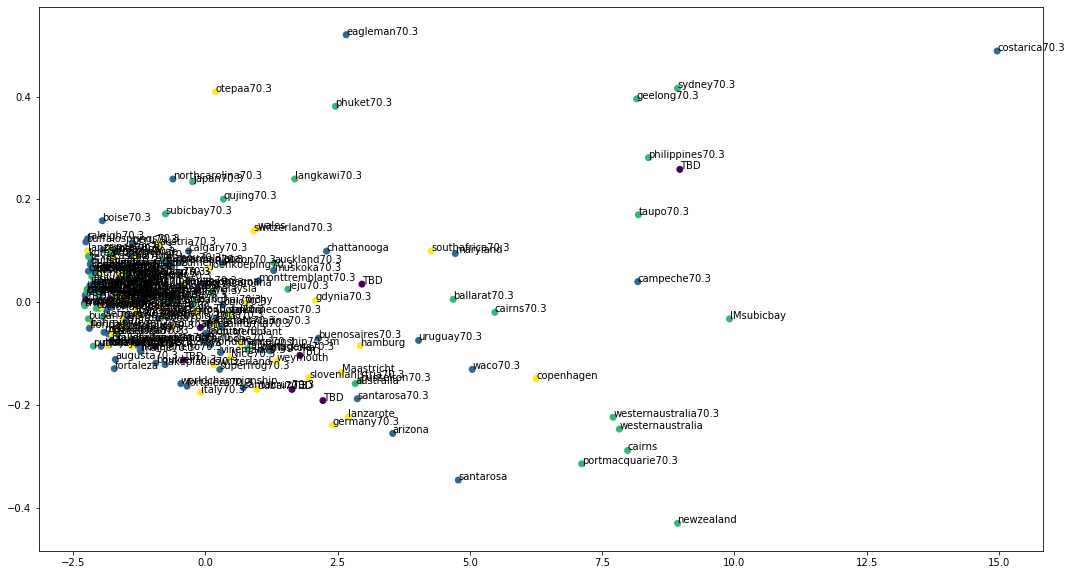

In [103]:
fig,ax = plt.subplots(figsize=(18, 10))
ax.scatter(out[:, 0], out[:, 1], c=pd.Categorical(data.region).codes)
for i, txt in enumerate(data.id):
    ax.annotate(txt, (out[i, 0], out[i, 1]))

In [101]:
pl = Pipeline(steps=[('doc2vec', Doc2VecTransformer(vector_size=20)),
                     ('pca', PCA(n_components=10)),
    ])
pl.fit(data[['description']])
res = pl.transform(data[['description']])

100%|██████████| 223/223 [00:00<00:00, 1143434.95it/s]


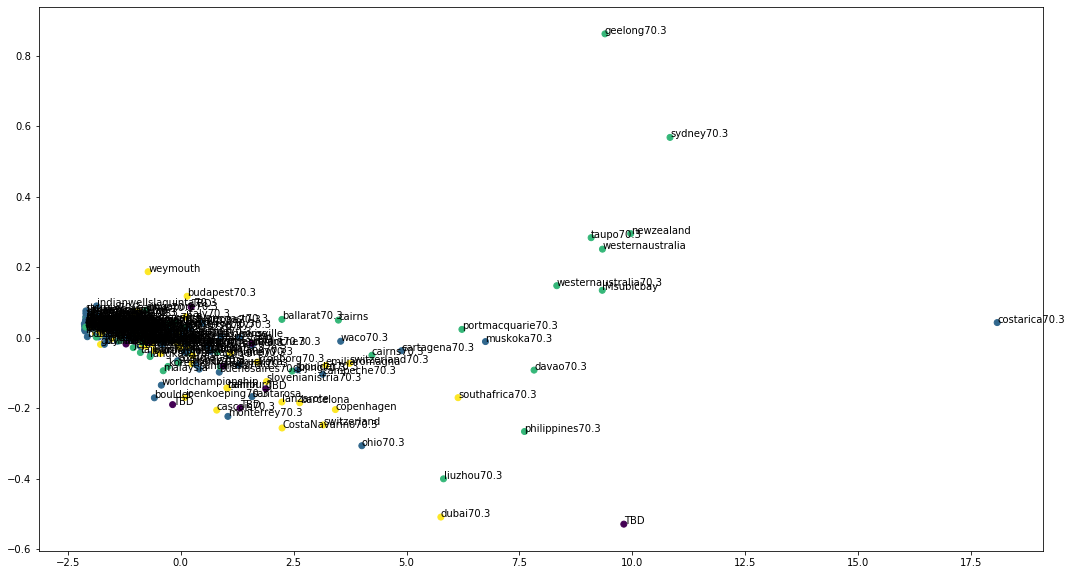

In [102]:
fig,ax = plt.subplots(figsize=(18, 10))
ax.scatter(res[:, 0], res[:, 1], c=pd.Categorical(data.region).codes)
for i, txt in enumerate(data.id):
    ax.annotate(txt, (res[i, 0], res[i, 1]))

In [105]:
from sklearn.model_selection import GridSearchCV

def train_long_range_grid_search():
    all_reviews_df = data
    train_x_df, test_x_df, train_y_df, test_y_df = train_test_split(all_reviews_df[['description']], all_reviews_df[['region']])
    pl = Pipeline(steps=[('doc2vec', Doc2VecTransformer()),
                         ('pca', PCA()),
                         ('logistic', LogisticRegression())
     ])
    param_grid = {
        'doc2vec__vector_size': [x for x in range(100, 250)],
        'pca__n_components': [x for x in range(1, 50)]
    }
    gs_cv = GridSearchCV(estimator=pl, param_grid=param_grid, cv=5, n_jobs=-1, scoring="accuracy")
    gs_cv.fit(train_x_df[['description']], train_y_df[['region']])
    print("Best parameter (CV score=%0.3f):" % gs_cv.best_score_)
    print(gs_cv.best_params_)
    predictions_y = gs_cv.predict(test_x_df[['description']])
    print('Accuracy: ', metrics.accuracy_score(y_true=test_y_df[['region']], y_pred=predictions_y))

In [106]:
def train_short_range_grid_search():
    all_reviews_df = data
    train_x_df, test_x_df, train_y_df, test_y_df = train_test_split(all_reviews_df[['description']], all_reviews_df[['region']])
    pl = Pipeline(steps=[('doc2vec', Doc2VecTransformer()),
                         ('pca', PCA()),
                         ('logistic', LogisticRegression())
     ])
    param_grid = {
        'doc2vec__vector_size': [200, 220, 250],
        'pca__n_components': [50, 75, 100]
    }
    gs_cv = GridSearchCV(estimator=pl, param_grid=param_grid, cv=3, n_jobs=-1, scoring="accuracy")
    gs_cv.fit(train_x_df[['description']], train_y_df[['region']])
    print("Best parameter (CV score=%0.3f):" % gs_cv.best_score_)
    print(gs_cv.best_params_)
    predictions_y = gs_cv.predict(test_x_df[['description']])
    print('Accuracy: ', metrics.accuracy_score(y_true=test_y_df[['region']], y_pred=predictions_y))

In [107]:
train_short_range_grid_search()

/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
100%|██████████| 167/167 [00:00<00:00, 860502.17it/s]


Best parameter (CV score=0.455):
{'doc2vec__vector_size': 220, 'pca__n_components': 50}
Accuracy:  0.6071428571428571


/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [90]:
test = pl.transform(data[['description']])
test = out

In [64]:
test.shape

(223, 10)

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

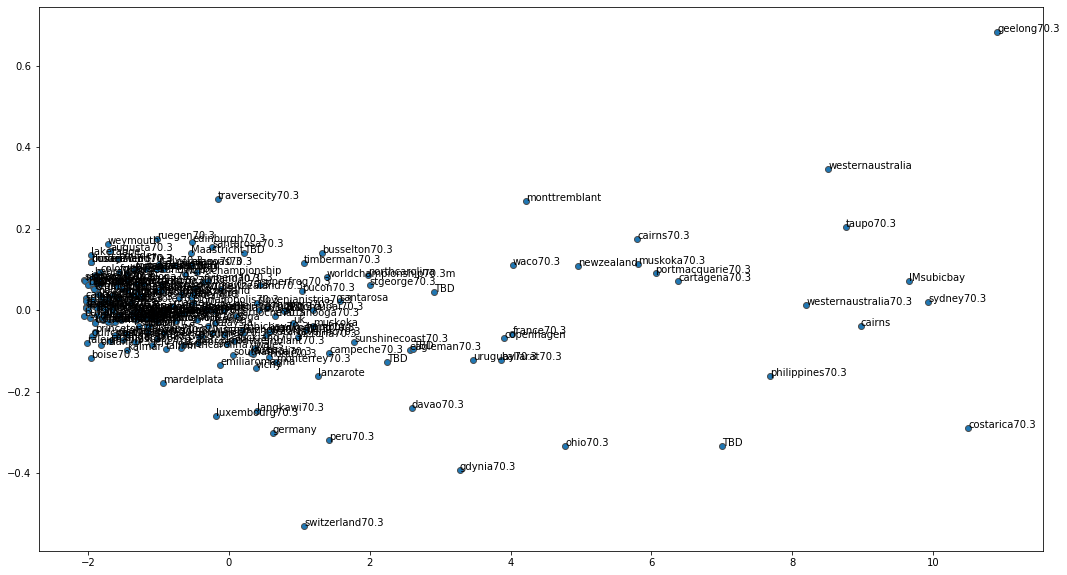

In [ ]:
def train_and_build_model(data):
    all_reviews_df = data#_read_all_reviews_()
    train_x_df, test_x_df, train_y_df, test_y_df = train_test_split(all_reviews_df[['description']], all_reviews_df[['region']])
    pl = Pipeline(steps=[('doc2vec', Doc2VecTransformer(vector_size=20)),
                         ('pca', PCA(n_components=10)),
                         ('logistic', LogisticRegression())
    ])
    pl.fit(train_x_df[['description']], train_y_df[['region']])
    predictions_y = pl.predict(test_x_df[['description']])
    print('Accuracy: ', metrics.accuracy_score(y_true=test_y_df[['region']], y_pred=predictions_y))

In [ ]:
train_and_build_model(pd.DataFrame(list(descriptions.values())))

In [5]:
# import gensim

In [ ]:
# gensim.models.Word2Vec()

In [63]:
import spacy


In [64]:
spacy.__version__

'2.1.4'

In [65]:
nlp = spacy.load("en_core_web_md")

In [100]:
customize_stop_words = [
    "Race", "Races", "race",
    "info", "about", 
    "finish", "line", "swim", "bike", "run", 'athlete', 'ironman'
]
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [119]:
import string

# Create our list of punctuation marks
punctuations = string.punctuation


def extended_is_stop(token):
    stop_words = nlp.Defaults.stop_words
    return token.is_stop or token.lower_ in stop_words or token.lemma_ in stop_words

def filterTokenByStop(doc):
    return [token for token in doc if not extended_is_stop(token)]

# Creating our tokenizer function
def spacy_tokenizer(tokens):
    # creating the filter list for tokens that are identified as person
#     toRemove = [ent for ent in tokens.ents if ent.label_.lower() in ["person"]]

    # Removing stop words
    mytokens = [ 
        word for word in tokens
            if not extended_is_stop(word) 
            and word.lower_ not in punctuations 
    ]
    
    # Removing stop words
    mytokens = [ word for word in tokens if not extended_is_stop(word) and word.lower_ not in punctuations ]

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # return preprocessed list of tokens
    return mytokens

In [68]:
# # add stop words
# nlp.Defaults.stop_words |= {"race","info"}


In [70]:
descriptions = {}

with open("./../data/races/races-description.jl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        if (data.get('id', "TBD") != "TBD"):
            descriptions[data['id']] = data
        else:
            descriptions[f"TBD_{data['name']}"] = data

In [71]:
len(descriptions)

223

In [72]:
for key in list(descriptions.keys())[1:2]:
    desc = descriptions[key]['description']
    doc = nlp(desc)

In [174]:
# print(f"--- {key} ---")
# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

# for ent in doc.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [102]:
race1,race2,race3 = list(descriptions.keys())[1:4]
desc1 = descriptions[race1]['description']
desc2 = descriptions[race2]['description']
desc3 = descriptions['santarosa']['description']
doc1 = nlp(desc1)
doc2 = nlp(desc2)
doc3 = nlp(desc3)

In [172]:
descriptions['mallorca70.3']['description']

'Races Mallorca The balearic island of Mallorca, host of the IRONMAN 70.3 Mallorca, is well known as a training paradise for triathletes from all over the world. The course takes athletes on a tour through many villages that offer incredible views and diversity. The event location, Alcúdia, is one of the most celebrated towns of Mallorca, with more than 30 km of the coastline made up of gorgeous, fine sand beaches, steep cliffs and secluded coves of great beauty. The area is equipped with the most modern infrastructures and a tranquil surrounding, making it ideal for relaxation. The unique destination has activities for all tastes that include water sports, trails and mountains for hiking, biking and golf. The country offers many nature areas, which attract tourists from all over the world. The small peninsula offers uncommonly rich landscapes, marked by the intense blue of the Mediterranean Sea. The temperate, pleasant climate makes it possible to partake in countless outdoor sports a

In [173]:
tags = ['family', 'award', 'kid', 'activity', 'nature', 'fast', 'slot', 'beginner', 'friendly', 'community', 'tourism', 'relax', 'relaxation', 'visit', 'discontinue']
for race in descriptions:
    has_tags = []
    desc = descriptions[race]['description']
    doc = nlp(desc)
    text = [token.lemma_.lower() for token in doc]
    for tag in tags:
        if tag in text:
            has_tags.append(tag)
    if len(has_tags)>0:
        print(race, has_tags)

mallorca70.3 ['activity', 'nature', 'slot', 'relaxation']
france70.3 ['award', 'slot']
australia ['slot', 'community']
portmacquarie70.3 ['family', 'nature', 'fast', 'slot', 'community']
vietnam70.3 ['award', 'fast', 'visit']
busselton70.3 ['award', 'activity', 'nature', 'fast', 'slot', 'visit']
marbella70.3 ['family', 'activity', 'slot']
texas ['slot']
liuzhou70.3 ['slot', 'friendly']
virginia70.3 ['slot']
CostaNavarino70.3 ['slot']
monterrey70.3 ['family', 'fast', 'slot', 'visit']
taiwan70.3 ['award', 'slot', 'visit']
southafrica ['award', 'fast', 'slot', 'visit']
newzealand ['award', 'slot', 'community']
davao70.3 ['nature', 'fast', 'slot', 'friendly', 'community']
peru70.3 ['fast', 'slot', 'tourism']
Florianopolis70.3 ['activity', 'fast', 'slot']
sanjuan70.3 ['slot', 'visit']
oman70.3 ['slot', 'tourism']
campeche70.3 ['fast', 'slot', 'friendly']
newzealand70.3 ['family', 'activity', 'nature', 'fast', 'slot', 'community', 'tourism']
pucon70.3 ['slot']
dubai70.3 ['award', 'fast', 'sl

In [87]:
doc1.similarity(doc2)

0.9711980364821625

In [76]:
doc1.similarity(doc3)

0.9638568698800685

In [77]:
doc3[0].lemma_

'Races'

In [36]:
extended_is_stop(doc3[0])

False

In [55]:
doc3[3].is_stop

False

In [43]:
test = nlp("races and me")

In [46]:
test[0].lemma_

'race'

In [61]:
tokens = [token.text for token in doc3 if not extended_is_stop(token)]
tokens

['Races',
 'Santa',
 'Rosa',
 'new',
 'Santa',
 'Rosa',
 'offers',
 'high',
 '-',
 'quality',
 'event',
 'come',
 'know',
 'love',
 'heart',
 'Sonoma',
 'County',
 ',',
 'winding',
 'roads',
 'dotted',
 'vineyards',
 'world',
 '-',
 'class',
 'accommodation',
 '.',
 'past',
 'results',
 'Vineman',
 ',',
 'visit',
 'event',
 'page',
 '.',
 'Staged',
 'beautiful',
 'Sonoma',
 'County',
 'traversing',
 'quaint',
 'communities',
 'like',
 'Geyersville',
 'Healdsburg',
 ',',
 'Santa',
 'Rosa',
 'draws',
 'triathletes',
 ',',
 'wine',
 'food',
 'loving',
 'family',
 'support',
 'crews',
 'year',
 '.',
 'event',
 'ticket',
 'heart',
 'world',
 '-',
 'famous',
 'wine',
 'regions',
 'Napa',
 'Sonoma',
 'valleys',
 ',',
 ',',
 'want',
 'leave',
 '.',
 'B&Bs',
 'boutique',
 'hotel',
 'options',
 'suit',
 'budget',
 ',',
 'thousands',
 'wineries',
 ',',
 'craft',
 'breweries',
 ',',
 'farm',
 '-',
 '-',
 'table',
 'restaurants',
 'pre',
 '-',
 'fueling',
 'post',
 '-',
 'celebrations',
 '.',
 'off

In [28]:
descriptions['santarosa']['description']

'Races Santa Rosa Reasons to Race IRONMAN Santa Rosa The 2020 IRONMAN Santa Rosa will offer 40 qualifying slots to the 2020 IRONMAN World Championship in Kailua-Kona, Hawaii.'

In [81]:
import nltk

In [83]:
from nltk.corpus import stopwords

In [175]:
# how many verbs? (more verbs more things to do?)